In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K

In [2]:
BATCH_SIZE = 16
SEED = 10349

IM_HEIGHT = 450
IM_WIDTH = 600

np.random.seed(SEED)

global_mean = np.load('Utils/np_mean_rounded_nonweighted.npz')['image']
global_std = np.load('Utils/np_std_rounded_nonweighted.npz')['image']

In [3]:
def preprocess_image(image):
    return (image - global_mean)/(global_std + K.epsilon())

In [4]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import compute_class_weight

img_gen = ImageDataGenerator(preprocessing_function=preprocess_image)

train_gen = img_gen.flow_from_directory('/home/ubuntu/Data/Skin/last_stage/train/', 
                                        target_size=(IM_HEIGHT, IM_WIDTH), 
                                        class_mode='categorical', 
                                        shuffle=True, 
                                        batch_size=BATCH_SIZE, 
                                        seed=SEED)

val_gen = img_gen.flow_from_directory('/home/ubuntu/Data/Skin/last_stage/val/', 
                                        target_size=(IM_HEIGHT, IM_WIDTH), 
                                        class_mode='categorical', 
                                        shuffle=True, 
                                        batch_size=BATCH_SIZE, 
                                        seed=SEED)

y_train = train_gen.classes
weights = compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = {i: weights[i] for i in range(len(weights))}
print('---------------------------------------')
print('Class weights: ', class_weights)
print('---------------------------------------')
print('Class indices: ', train_gen.class_indices)

Found 1611 images belonging to 4 classes.
Found 402 images belonging to 4 classes.
---------------------------------------
Class weights:  {0: 1.0093984962406015, 1: 0.975181598062954, 2: 1.0093984962406015, 3: 1.006875}
---------------------------------------
Class indices:  {'AKIEC': 0, 'BCC': 1, 'DF': 2, 'VASC': 3}


In [5]:
from keras.applications.inception_v3 import InceptionV3
from keras import Model
from keras.layers import (Dense, Activation, Dropout, 
                          BatchNormalization, Flatten, GlobalAveragePooling2D)

inc = InceptionV3(include_top=False, input_shape=(IM_HEIGHT, IM_WIDTH, 3), weights='imagenet')
x = inc.output
x = GlobalAveragePooling2D()(x)
x = Dense(16)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)

out = Dense(4, activation='softmax')(x)

model = Model(inputs=inc.input, outputs=out)

for i, layer in enumerate(model.layers):
    if type(layer) is BatchNormalization:
        layer = BatchNormalization()(model.layers[i-1].output)

for layer in inc.layers:
    layer.trainable = False

In [6]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

_ = model.fit_generator(train_gen, 
                        steps_per_epoch=train_gen.samples//BATCH_SIZE + 1, 
                        validation_data=val_gen, 
                        validation_steps=val_gen.samples//BATCH_SIZE + 1, 
                        shuffle=True, 
                        epochs=1, 
                        class_weight=class_weights)

Epoch 1/1
101/101 [==============================] - 56s 555ms/step - loss: 1.1758 - val_loss: 1.3939


In [7]:
def f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return ( 2*(precision * recall) / (precision + recall + K.epsilon()) )

In [8]:
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return (true_positives / (predicted_positives + K.epsilon()))

In [9]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return (true_positives / (possible_positives + K.epsilon()))

In [10]:
from keras.optimizers import Adam

for layer in model.layers:
    layer.trainable = True

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4, decay=0.005),
              metrics=['categorical_accuracy', precision, recall, f1])

print('Model compiled for fine tuning')

Model compiled for fine tuning


Epoch 1/40
101/101 [==============================] - 149s 1s/step - loss: 0.7884 - categorical_accuracy: 0.6724 - precision: 0.7765 - recall: 0.4704 - f1: 0.5821 - val_loss: 0.8559 - val_categorical_accuracy: 0.6866 - val_precision: 0.8080 - val_recall: 0.5647 - val_f1: 0.6602

Epoch 00001: val_f1 improved from -inf to 0.66023, saving model to inception--baseline--2--adam.h5
Epoch 2/40
101/101 [==============================] - 128s 1s/step - loss: 0.5962 - categorical_accuracy: 0.7859 - precision: 0.9111 - recall: 0.5976 - f1: 0.7168 - val_loss: 0.7862 - val_categorical_accuracy: 0.6990 - val_precision: 0.8676 - val_recall: 0.5970 - val_f1: 0.7043

Epoch 00002: val_f1 improved from 0.66023 to 0.70431, saving model to inception--baseline--2--adam.h5
Epoch 3/40
101/101 [==============================] - 128s 1s/step - loss: 0.5399 - categorical_accuracy: 0.8336 - precision: 0.9415 - recall: 0.6517 - f1: 0.7657 - val_loss: 0.7231 - val_categorical_accuracy: 0.7239 - val_precision: 0.925

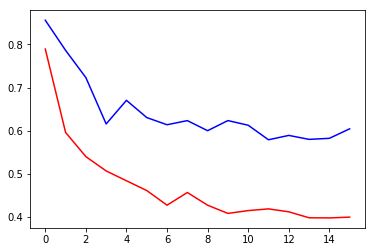

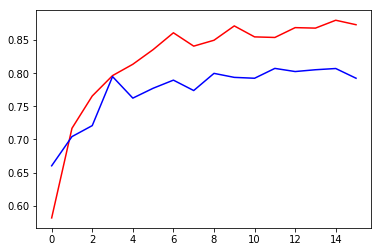

In [11]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint('inception--baseline--2--adam.h5', 
                             save_best_only=True, mode='max',
                             monitor='val_f1', verbose=1)

stopper = EarlyStopping(monitor='val_loss', mode='min', patience=4)

h = model.fit_generator(train_gen, 
                        steps_per_epoch=train_gen.samples//BATCH_SIZE + 1, 
                        validation_data=val_gen, 
                        validation_steps=val_gen.samples//BATCH_SIZE + 1, 
                        shuffle=True, 
                        epochs=40, 
                        class_weight=class_weights, 
                        callbacks=[checkpoint, stopper])

fig = plt.figure()
plt.plot(h.history['loss'], 'r-')
plt.plot(h.history['val_loss'], 'b-')
plt.show()

fig = plt.figure()
plt.plot(h.history['f1'], 'r-')
plt.plot(h.history['val_f1'], 'b-')
plt.show()